In [2]:
# COMPUTE METRIC FOR SHARED LEXICAL ITEMS FOR LANGUAGES PAIRWISE, OUTPUT: SIMILARITY MATRIX

In [1]:
import os, sys
sys.path.append("../")
from crawled_data import CrawledData
from collections import Counter
from itertools import combinations
import pandas as pd
import math
import json
import string
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
# READ DATA

In [3]:
data_obj = CrawledData()
data_obj.read_crawled_data("../data/crawled/folksongs/", remove_punctuation = True)
print(data_obj.data.keys())
data_obj.read_crawled_data("../data/crawled/poetry/", remove_punctuation = True)
print(data_obj.data.keys())


Getting files for rajasthani
Getting files for gujarati
Getting files for himachali
Getting files for hindi-urdu
Getting files for magahi
Getting files for awadhi
Getting files for punjabi
Getting files for koraku
Getting files for baiga
Getting files for .DS_Store
Getting files for nimaadi
Getting files for khadi_boli
Getting files for bhojpuri
Getting files for garwali
Getting files for chattisgarhi
Getting files for brajbhasha
Getting files for bhil
Getting files for sanskrit
Getting files for angika
Getting files for hariyanvi
Getting files for kannauji
Getting files for bundeli
Getting files for bangla
Getting files for malwi
Getting files for marathi
Getting files for kumaoni
Getting files for bhadavari
dict_keys(['rajasthani', 'gujarati', 'himachali', 'hindi-urdu', 'magahi', 'awadhi', 'punjabi', 'koraku', 'baiga', 'nimaadi', 'khadi_boli', 'bhojpuri', 'garwali', 'chattisgarhi', 'brajbhasha', 'bhil', 'sanskrit', 'angika', 'hariyanvi', 'kannauji', 'bundeli', 'bangla', 'malwi', 'mar

In [4]:
# ORDERING LANGUAGES ROUGHLY FROM WEST TO EAST

In [5]:
def get_langs():

    langs = [
"sindhi",
"rajasthani",
"punjabi",
"hariyanvi",
#"gujarati",
"khadi_boli",
#"sanskrit",
"hindi-urdu",
"bhil",
"koraku",
"baiga",
"nimaadi",
"malwi",
"marathi",
"bhadavari",
"himachali",
"garwali",
"kumaoni",
"kannauji",
"brajbhasha",
"bundeli",
"awadhi",
"chattisgarhi",
"nepali",
#"pali",
"bhojpuri",
"bajjika",
"magahi",
"maithili",
"angika",
#"bangla"
        ]
    return langs

langs = get_langs()

In [6]:
#Character wise cleaning of accumulated data

acc_data = dict()
dev_range = range(2305, 2404)
for lang in langs:
    acc_data[lang] = " ".join([data_obj.data[lang][file_id]["text"] for file_id in data_obj.data[lang]])
    acc_data[lang] = "".join([c if ord(c) in dev_range else " " for c in acc_data[lang]])
    acc_data[lang] = " ".join(acc_data[lang].split())



In [7]:
# First, we "clean" the dictionary, i.e. we remove words that occur only 1 time

word_set = dict()
for lang in langs:
    print(lang)
    word_set[lang] = Counter(acc_data[lang].split())
    print("Number of unique words: ", len(word_set[lang]))
    lexicon = set(word_set[lang].keys())
    threshold = math.log(len(acc_data[lang].split()), 100) - 1
    for word in lexicon:
        if word_set[lang][word] < threshold:
            del word_set[lang][word]
    
    print("Threshold: ", threshold)
    print("Post cleaning: ", len(word_set[lang]))




sindhi
Number of unique words:  11850
Threshold:  1.3607363037750213
Post cleaning:  4693
rajasthani
Number of unique words:  34360
Threshold:  1.6367413911903124
Post cleaning:  13888
punjabi
Number of unique words:  15111
Threshold:  1.4171721967041786
Post cleaning:  5695
hariyanvi
Number of unique words:  27431
Threshold:  1.6832357603876424
Post cleaning:  12969
khadi_boli
Number of unique words:  1442
Threshold:  0.8240823892870004
Post cleaning:  1442
hindi-urdu
Number of unique words:  197355
Threshold:  2.4256412241678675
Post cleaning:  68194
bhil
Number of unique words:  5557
Threshold:  1.217651376142305
Post cleaning:  2837
koraku
Number of unique words:  2278
Threshold:  1.0952778961675858
Post cleaning:  1969
baiga
Number of unique words:  3098
Threshold:  1.0684712063876836
Post cleaning:  1533
nimaadi
Number of unique words:  4025
Threshold:  1.0696246087858032
Post cleaning:  1700
malwi
Number of unique words:  2883
Threshold:  0.9917229286706697
Post cleaning:  2883


In [26]:
# Pick the subset of langs

north = ["sindhi", "punjabi", "hariyanvi", "bhadavari", "himachali", "garwali", "kumaoni", "kannauji", "nepali"]
north_central = ["sindhi", "rajasthani", "punjabi", "hariyanvi", "hindi-urdu", "khadi_boli", "kannauji", "brajbhasha", "bundeli", \
                "awadhi", "chattisgarhi", "bhojpuri", "bajjika", "magahi", "maithili", "angika"]
central = ["rajasthani", "hindi-urdu", "bhil", "koraku", "baiga", "nimaadi", "malwi", "marathi", "chattisgarhi"]

langs = [lang for lang in get_langs() if lang in north_central]

for idx, lang in enumerate(langs):
    print(idx, lang)

0 sindhi
1 rajasthani
2 punjabi
3 hariyanvi
4 khadi_boli
5 hindi-urdu
6 kannauji
7 brajbhasha
8 bundeli
9 awadhi
10 chattisgarhi
11 bhojpuri
12 bajjika
13 magahi
14 maithili
15 angika


In [27]:
# len(acc_data["gujarati"])

In [28]:
# SIMILARITY MATRIX: THE SIMILARITY METRIC USED IS |S|/MIN(|L_1,|L_2|) WHERE S IS THE SHARED LEXICON OF 2 LANGUAGE
# LEXICONS L_1 AND L_2

In [29]:
N = len(langs)
shared_lex_metrics = [[0]*N for _ in range(N)]
shared_lex_dict = {lang:dict() for lang in langs}

for i, j in combinations(range(N), 2):
    l_1, l_2 = langs[i], langs[j]
    lex_l_1, lex_l_2 = set(word_set[l_1].keys()), set(word_set[l_2].keys())
#     print("CALCULATING FOR LANGS {}: SIZE {} and {}: SIZE {}".format(l_1, len(lex_l_1), l_2, len(lex_l_2)))
    shared_lex = lex_l_1.intersection(lex_l_2)
#     print("SHARED VOCABULARY: {}".format(len(shared_lex)))
#     print(list(shared_lex)[:100])
    normalization = min(len(lex_l_1),len(lex_l_2))
#     normalization = (len(lex_l_1)+len(lex_l_2))/2
    shared_lex_metrics[i][j] = len(shared_lex)/(normalization)
    shared_lex_metrics[j][i] = len(shared_lex)/(normalization)
    
    shared_lex_dict[l_1][l_2] = len(shared_lex)/(normalization)
    shared_lex_dict[l_2][l_1] = len(shared_lex)/(normalization)

shared_lex_metrics = np.asarray(shared_lex_metrics)
max_sim = max(shared_lex_metrics.flatten())
    
for i in range(N):
    shared_lex_metrics[i][i] = 1
    shared_lex_dict[langs[i]][langs[i]] = 1

In [30]:
# with open("stats_outputs/lexical_similarity/pairwise_lex_similarity.json", "w") as f:
#     json.dump(shared_lex_dict, f, indent = 2, ensure_ascii = False)

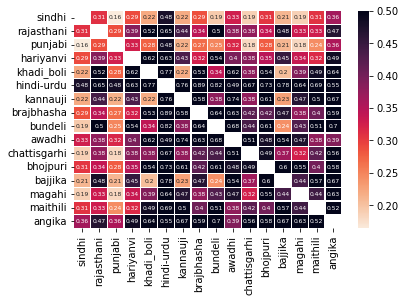

In [31]:
ax = sns.heatmap(shared_lex_metrics, cmap = "rocket_r", linewidth=0.3, mask = shared_lex_metrics == 1, vmax = 0.5, xticklabels=langs, yticklabels=langs, annot=True, annot_kws={"size":6})

# plt.()
fig = ax.get_figure()
fig.savefig("stats_outputs/lexical_similarity_new/north_central.png", bbox_inches = "tight")

In [80]:
for lang in acc_data:
    print(lang, len((acc_data[lang].split())))

rajasthani 187724
gujarati 75158
himachali 466
hindi-urdu 7127997
magahi 84754
awadhi 500079
punjabi 69595
koraku 15509
baiga 13848
nimaadi 14056
khadi_boli 4507
bhojpuri 197639
garwali 92668
chattisgarhi 83226
brajbhasha 160039
bhil 27326
sanskrit 95634
angika 1265146
hariyanvi 233003
kannauji 327
bundeli 26928
bangla 838
malwi 9626
marathi 3327
kumaoni 1028
bhadavari 990
bajjika 7414
maithili 218339
pali 5859
sindhi 51458
nepali 692657


In [ ]:
# INTERPRETING HEATMAPS

In [46]:
l1="hindi-urdu"
s = Counter(acc_data[l1].split())
l = sorted(s.items(), key=lambda x:x[1])

In [100]:
# l[120000:120100]

In [20]:
# with open("stats_outputs/word_frequency.json", "r") as f:
#     word_freq = json.load(f)

In [27]:
l1 = "marathi"
l2 = "angika"
s = list(set(acc_data[l1].split()).intersection(set(acc_data[l2].split())))
print("COMMON WORDS, ", len(s))
print("")

for word in s:
    print(word)
    print(l1 , word_freq[l1][word])
    print(l2, word_freq[l2][word])
    print("\n\n")



COMMON WORDS,  802

रूप
marathi 0.24
angika 0.105



प्राप्त
marathi 0.03
angika 0.006



कृपा
marathi 0.03
angika 0.016



हमें
marathi 0.15
angika 0.011



काज
marathi 0.06
angika 0.016



कहे
marathi 0.12
angika 0.008



काया
marathi 0.03
angika 0.017



चाहे
marathi 0.03
angika 0.017



इसमें
marathi 0.03
angika 0.006



माय
marathi 0.12
angika 0.134



संगत
marathi 0.06
angika 0.004



फेरा
marathi 0.03
angika 0.006



बघ
marathi 0.03
angika 0.0



लोभी
marathi 0.06
angika 0.003



घरा
marathi 0.03
angika 0.001



लोगे
marathi 0.03
angika 0.002



बात
marathi 0.03
angika 0.177



खाय
marathi 0.03
angika 0.047



काठी
marathi 0.03
angika 0.003



अपने
marathi 0.15
angika 0.058



बिरला
marathi 0.03
angika 0.002



किती
marathi 0.03
angika 0.0



उसका
marathi 0.03
angika 0.009



पद
marathi 0.03
angika 0.018



दूसरों
marathi 0.24
angika 0.0



हम
marathi 0.06
angika 0.144



कोना
marathi 0.09
angika 0.012



५
marathi 0.12
angika 0.002



अत
marathi 0.03
angika 0.0



राग
marathi 0




रहते
marathi 0.09
angika 0.008



पाए
marathi 0.03
angika 0.003



मांडवी
marathi 0.06
angika 0.001



जिससे
marathi 0.06
angika 0.003



कृष्णा
marathi 0.03
angika 0.005



बसती
marathi 0.03
angika 0.001



जी
marathi 0.09
angika 0.144



या
marathi 0.09
angika 0.064



बोध
marathi 0.03
angika 0.006



१०
marathi 0.03
angika 0.002



फुल
marathi 0.03
angika 0.001



लिए
marathi 0.271
angika 0.036



२४
marathi 0.03
angika 0.001



कांही
marathi 0.03
angika 0.002



मोती
marathi 0.03
angika 0.015



जिव्हा
marathi 0.09
angika 0.0



आलिंगन
marathi 0.03
angika 0.002



कु
marathi 0.03
angika 0.001



जया
marathi 0.06
angika 0.0



ग़लती
marathi 0.03
angika 0.0



भ्रांति
marathi 0.03
angika 0.0



कंचन
marathi 0.03
angika 0.009



नहीं
marathi 0.331
angika 0.243



अरे
marathi 0.09
angika 0.007



बैठ
marathi 0.03
angika 0.006



बोलती
marathi 0.03
angika 0.001



जाते
marathi 0.03
angika 0.01



कौड़ी
marathi 0.06
angika 0.003



हुए
marathi 0.12
angika 0.027



कोण
marathi 0.12
ang

In [23]:
print("hindi-urdu ", word_freq["hindi-urdu"]["म्हारै"])

hindi-urdu  0.0


In [131]:
sorted(word_set["punjabi"].items(), key = lambda x: x[1], reverse=True)[:100]

[('दे', 1370),
 ('नी', 1028),
 ('दा', 903),
 ('ते', 762),
 ('नूं', 747),
 ('ने', 724),
 ('ए', 720),
 ('दी', 704),
 ('ना', 693),
 ('के', 604),
 ('नाल', 595),
 ('शाह', 518),
 ('मैं', 506),
 ('1', 493),
 ('वारस', 471),
 ('है', 466),
 ('ई', 460),
 ('विच', 420),
 ('जे', 339),
 ('एह', 336),
 ('वे', 336),
 ('2', 323),
 ('हो', 305),
 ('कोई', 278),
 ('नहीं', 269),
 ('हीर', 245),
 ('नूँ', 222),
 ('मियां', 215),
 ('जी', 213),
 ('3', 199),
 ('की', 197),
 ('आप', 184),
 ('कर', 184),
 ('विच्च', 181),
 ('तों', 180),
 ('इक', 178),
 ('कीता', 177),
 ('इशक', 175),
 ('यार', 174),
 ('तेरे', 173),
 ('रब्ब', 169),
 ('न', 166),
 ('लै', 165),
 ('आया', 163),
 ('किसे', 152),
 ('चा', 152),
 ('हां', 150),
 ('बुल्ला', 148),
 ('होया', 146),
 ('मार', 145),
 ('हुण', 145),
 ('जो', 139),
 ('गल', 135),
 ('जा', 129),
 ('घर', 129),
 ('मेरे', 127),
 ('क्यों', 126),
 ('तूं', 126),
 ('सभ', 124),
 ('असां', 123),
 ('होर', 122),
 ('दियां', 120),
 ('मेरा', 117),
 ('हथ', 114),
 ('तेरी', 114),
 ('फकीर', 113),
 ('आ', 113),
 ('नाहीं',